<h1> Laboratory work 2:  Named-entity recognition (NER) </h1>

Authors: Aleksei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion/data" target="_blank">  CoNLL003 (English-version) </a> is used.

In this laboratory work, we explore the fundamentals of Named Entity Recognition (NER), a key NLP task that identifies and categorizes entities in text, such as persons, organizations, and locations. NER is widely used in applications like information extraction and text analysis.

We will use the CoNLL-2003 dataset, a benchmark for NER, which provides annotated text in English and German. In this work, we consider only English language. For English, the dataset includes training, validation, and test sets, with entity categories such as Person (PER), Organization (ORG), Location (LOC), and Miscellaneous (MISC). The annotations follow the BIO tagging scheme, marking tokens as Beginning (B), Inside (I), or Outside (O) of entities.

In [1]:
import pandas as pd
from src.preprocessing import (set_seed,
                               load_sentences,
                               analyze_data_quality,
                               label_frequency_analysis,
                               labels_distribution_charts,
                               rare_and_dominant_categories,
                               entity_neighbors, plot_multiple_entity_neighbors,
                               generate_wordcloud_from_tokens_on_subplots,
                               remove_duplicates, remove_noise_from_data,
                               remove_stop_words_from_dataset,
                               remove_special_characters_from_dataset,
                               evaluate_ner
                               )
from src.RuleBasedApproach import RuleBasedNER

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Download data

In [2]:
train_samples = load_sentences('./data/train.txt')
test_samples = load_sentences('./data/test.txt')
valid_samples = load_sentences('./data/valid.txt')

In [3]:
schema = ['_'] + sorted({tag for sentence in (train_samples + test_samples + valid_samples) 
                             for _, tag in sentence})
schema

['_',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O']

There total have four NER types, LOC, MISC, ORG, PER, combine with the three location type, B,I,O. This task is a 9 classification task.

* O - word doesn’t correspond to any entity.
* B-PER/I-PER - word corresponds to the beginning of / is inside a person entity.
* B-ORG/I-ORG - word corresponds to the beginning of / is inside an organization entity.
* B-LOC/I-LOC - word corresponds to the beginning of / is inside a location entity.
* B-MISC/I-MISC - word corresponds to the beginning of / is inside a miscellaneous entity.

## EDA


### General information about the dataset

In [4]:
print(f"Train set length: {len(train_samples)}, leghth of the longest sentence is {max([len(item) for item in train_samples])}")
print(f"Valid set length: {len(valid_samples)}, leghth of the longest sentence is {max([len(item) for item in valid_samples])}")
print(f"Test set length: {len(test_samples)}, leghth of the longest sentence is {max([len(item) for item in test_samples])}")

Train set length: 14041, leghth of the longest sentence is 113
Valid set length: 3250, leghth of the longest sentence is 109
Test set length: 3453, leghth of the longest sentence is 124


In [5]:
print(f"Train dataset quality:\n {analyze_data_quality(train_samples)}")
print(f"Test dataset quality:\n {analyze_data_quality(test_samples)}")
print(f"Validation dataset quality:\n {analyze_data_quality(valid_samples)}")


Train dataset quality:
 {'total_tokens': 203621, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Test dataset quality:
 {'total_tokens': 46435, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Validation dataset quality:
 {'total_tokens': 51362, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}


### Analysis of entity categories

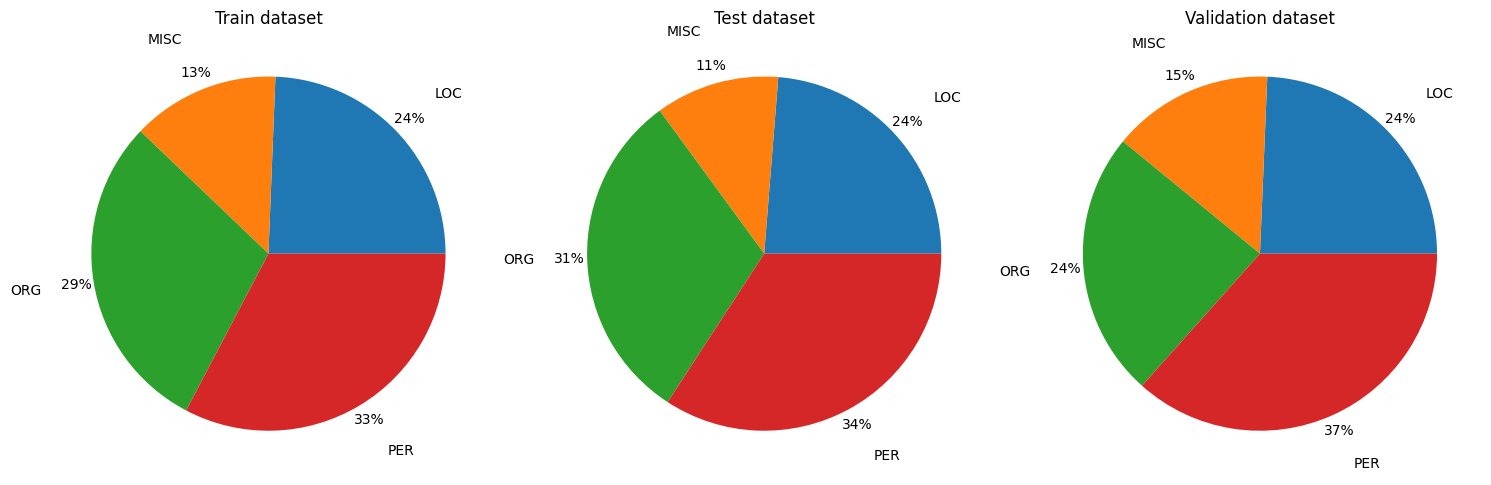

In [6]:
labels_distribution_charts(
    label_frequency_analysis(train_samples),
    label_frequency_analysis(test_samples),
    label_frequency_analysis(valid_samples),
    )

In [7]:
print(f"Rare and dominant entities in train dataset:\n {rare_and_dominant_categories(train_samples)}")
print(f"Rare and dominant entities in test dataset:\n {rare_and_dominant_categories(test_samples)}")
print(f"Rare and dominant entities in validation dataset:\n {rare_and_dominant_categories(valid_samples)}")

Rare and dominant entities in train dataset:
 {'total_tokens': 203621, 'top_categories': {'B-LOC': 3.506514553999833, 'O': 83.2811939829389}, 'worst_categories': {'I-MISC': 0.5672302954999731, 'I-LOC': 0.5682125124618777}}
Rare and dominant entities in test dataset:
 {'total_tokens': 46435, 'top_categories': {'B-LOC': 3.592118014428771, 'O': 82.53041886508022}, 'worst_categories': {'I-MISC': 0.4651663615807042, 'I-LOC': 0.5534618283622268}}
Rare and dominant entities in validation dataset:
 {'total_tokens': 51362, 'top_categories': {'B-PER': 3.58630894435575, 'O': 83.25026284023208}, 'worst_categories': {'I-LOC': 0.5003699232895915, 'I-MISC': 0.6736497799929909}}


<b>NOTE</b>

<b>Data distribution</b>
Based on the provided pie charts, we can see how the entity classes are distributed in the three datasets (training, test and validation):

1. Train dataset:

PER (33%): Predominant class. This indicates a large number of personal entities in the data.
ORG (29%): Nearly one-third of the data contains mentions of organizations.
LOC (24%): A significant proportion of the data refers to geographic entities.
MISC (13%): The lowest proportion of entities, possibly due to less certainty in their classification.

2. Test dataset:

PER (34%): The most represented class, the proportion is slightly higher than in the training sample.
ORG (31%): Organizations also make up a significant portion of the data.
LOC (24%): The level is the same as in the training sample.
MISC (11%): The rarest class, the proportion is even smaller than in the training sample.

3. Validation dataset:

PER (37%): Maximum proportion compared to other samples. This may create some imbalance.
ORG (24%): Decrease compared to other sets.
LOC (24%): Stable level.
MISC (15%): Highest proportion among all sets.



<b>Data balance:</b>

The main entity types (PER, ORG, LOC) are fairly evenly distributed, although PER is the most dominant class.
Entities of type MISC occupy a significantly smaller proportion, especially in the test sample. This may lead to insufficient generalization of the model for such entities.

<b>Differences between datasets:</b>

The validation set has a higher proportion of PER class than the other sets. This may bias the model quality assessment towards this class.
The proportion of ORG is lower in the validation sample, which may affect the correctness of the estimation for entities.

<b>Model complexity:</b>

Due to the presence of 9 classes, classification requires considering not only the type of entity, but also the position of the word within the entity (beginning or continuation). This increases the complexity of the task, especially for rare classes such as MISC.



### WordCloud

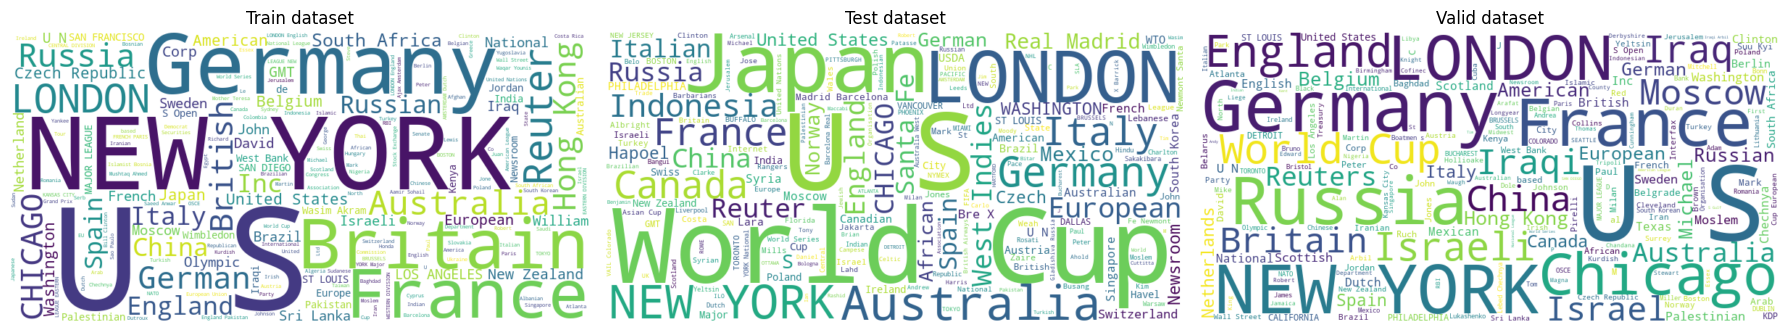

In [8]:
generate_wordcloud_from_tokens_on_subplots(
    train_samples, 
    test_samples, 
    valid_samples
)

<b>NOTE</b>

<b>General observations:</b>

The major entities repeated in each dataset are NEW YORK, U.S., GERMANY, FRANCE, and LONDON. This indicates that the data has some similarity in the composition of key entities.
Mentions of countries, cities, organizations and other international entities are predominant, which is consistent with the task of recognizing geographical and organizational entities.

* <b> Train dataset:</b>
Entities such as NEW YORK, U.S., GERMANY, LONDON, FRANCE are frequent, reflecting an emphasis on international entities and cities.
A variety of entities related to specific regions are present, e.g. SAN DIEGO, HONG KONG, AUSTRALIA.
Mention of news sources such as Reuters suggests possible use of texts from news stories.

* <b> Test dataset: </b> 
Frequent entities are similar to the training sample: NEW YORK, JAPAN, U.S., LONDON, FRANCE.
There is increased representation of Asian countries such as JAPAN, INDONESIA, CHINA.
Sports references such as World Cup are present, which may indicate sports-related texts.

* <b>  Validation dataset: </b> 
Frequent entities include NEW YORK, GERMANY, FRANCE, RUSSIA, which creates overlap with other sets.
References to countries with a tense political or international agenda are present, e.g. IRAQ, PALESTINIAN, which may indicate the theme of geopolitics in the texts.

<b>Comparative Analysis:</b>
* <b>Similarity:</b>
All three samples have significant overlap in key entities such as NEW YORK, U.S., GERMANY, FRANCE, which provides consistency across datasets and may contribute to better model training.
* <b>Differences:</b>
The validation sample stands out with a greater emphasis on Asian countries (JAPAN, INDONESIA) and sporting events (World Cup).
The validation sample has more entities related to political agenda and international conflicts (IRAQ, PALESTINIAN, ISRAELI).

### Proposition-level analysis

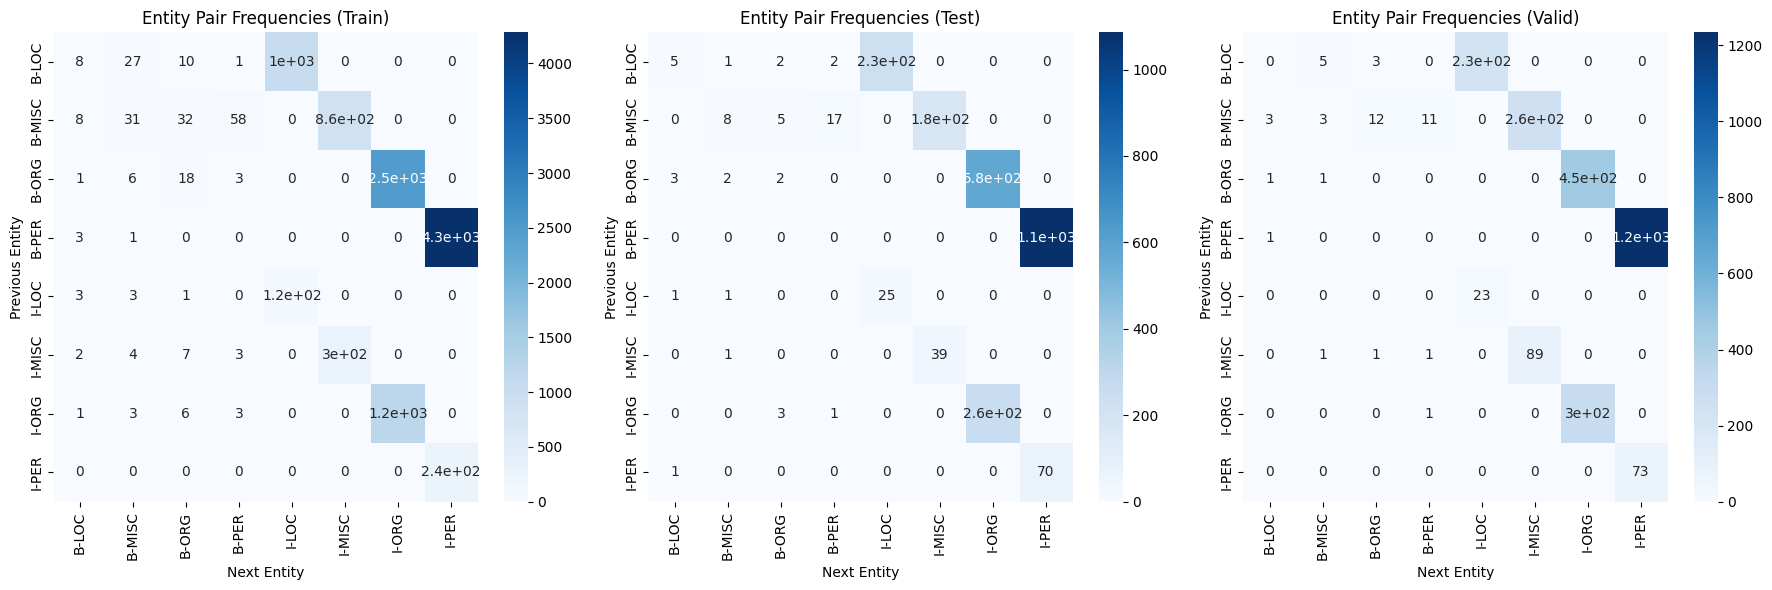

In [9]:
plot_multiple_entity_neighbors(
    entity_neighbors(train_samples),
    entity_neighbors(test_samples),
    entity_neighbors(valid_samples)
)

<b> NOTE</b>

<b>Frequent entity pairs:</b>

In each dataset, there is a high frequency of transitions between similar entities (e.g., B-LOC → I-LOC, B-PER → I-PER, B-ORG → I-ORG). This indicates that entities tend to have multiple tokens (words within the same entity).

<b>Rare transitions:</b>

Transitions between different entity types (e.g., B-LOC → B-ORG or B-MISC → B-PER) are less frequent, which is consistent with the nature of texts, where entities are usually contextually related within the same type.
Some transitions are almost absent, indicating that the data is strictly structured (e.g., I-LOC → B-ORG).

<b>Comparison of datasets:</b>

Training sample: Most balanced, with frequent transitions well represented, e.g., B-ORG → I-ORG and B-PER → I-PER.
Test sample: There is a decrease in the frequency of transitions, especially between different types of entities. This may be indicative of the more “narrow” subject matter of the data.
Validation sample: Also shows less pronounced transitions between different entities, which is probably due to the smaller amount of data.

The most frequent transitions are:
B-PER → I-PER: Occurs frequently in all sets, which is logical for first and last names.
B-LOC → I-LOC: Occurs frequently because geographic names are often composed of several words (e.g., New York).
B-ORG → I-ORG: Transitions within organizations are also quite frequent.

### Remove duplicate

In [10]:
train_samples = remove_duplicates(train_samples)
test_samples = remove_duplicates(test_samples)
valid_samples = remove_duplicates(valid_samples)

### Remove noise data

In [11]:
train_samples = remove_noise_from_data(train_samples)
test_samples = remove_noise_from_data(test_samples)
valid_samples = remove_noise_from_data(valid_samples)

### Remove stop word

In [12]:
train_samples = remove_stop_words_from_dataset(train_samples)
test_samples = remove_stop_words_from_dataset(test_samples)
valid_samples = remove_stop_words_from_dataset(valid_samples)

### Remove special characters

In [13]:
train_samples = remove_special_characters_from_dataset(train_samples)
test_samples = remove_special_characters_from_dataset(test_samples)
valid_samples = remove_special_characters_from_dataset(valid_samples)

<b> NOTE </b>

Removing duplicates, noise, stop words and special characters improves the quality of the training sample. It helps the model:

Focus on meaningful patterns.
Speed up training by reducing the amount of irrelevant data.
Increase robustness to errors and reduce the likelihood of overtraining.

## Rule based approach


In [14]:
from typing import List

def create_corpus(token_sentences: List[list]) -> dict:
    dataset_corpus = []
    for sentence in token_sentences:
        tokens = [token for token, _ in sentence]
        dataset_corpus.append({'text': " ".join(tokens),
                               'target':  sentence})
    return dataset_corpus

In [15]:
train_dataset = create_corpus(train_samples)
test_dataset = create_corpus(test_samples)
val_dataset = create_corpus(valid_samples)

### Testing

In [ ]:
#  A test set to verify that the rules work
custom_dataset = [
    {"text": "John works at OpenAI Inc.", "target": [("John", "B-PER"), ("works", "O"), ("at", "O"), ("OpenAI", "B-ORG"), ("Inc.", "I-ORG")]},
    {"text": "Google LLC and Apple are competitors.", "target": [("Google", "B-ORG"), ("LLC", "I-ORG"), ("and", "O"), ("Apple", "B-ORG"), ("are", "O"), ("competitors", "O")]},
    {"text": "Dr. Smith visited Berlin.", "target": [("Dr.", "O"), ("Smith", "B-PER"), ("visited", "O"), ("Berlin", "B-LOC")]},
    {"text": "Tesla Inc. is an innovative company.", "target": [("Tesla", "B-ORG"), ("Inc.", "I-ORG"), ("is", "O"), ("an", "O"), ("innovative", "O"), ("company", "O")]},
]


ner = RuleBasedNER()
for sample in custom_dataset:
    text = sample["text"]
    target = sample["target"]

    rule_based_prediction = ner.process_text(text)
    print(f"Text: {text}")
    print(f"Target: {target}")
    print(f"Rule-Based Prediction: {rule_based_prediction}")
    print("-" * 50)


Text: John works at OpenAI Inc.
Target: [('John', 'B-PER'), ('works', 'O'), ('at', 'O'), ('OpenAI', 'B-ORG'), ('Inc.', 'I-ORG')]
Rule-Based Prediction: [('John', 'B-PER'), ('works', 'O'), ('at', 'O'), ('OpenAI', 'B-ORG'), ('Inc.', 'I-ORG')]
--------------------------------------------------
Text: Google LLC and Apple are competitors.
Target: [('Google', 'B-ORG'), ('LLC', 'I-ORG'), ('and', 'O'), ('Apple', 'B-ORG'), ('are', 'O'), ('competitors', 'O')]
Rule-Based Prediction: [('Google', 'B-PER'), ('LLC', 'I-PER'), ('and', 'O'), ('Apple', 'B-PER'), ('are', 'O'), ('competitors', 'O'), ('.', 'O')]
--------------------------------------------------
Text: Dr. Smith visited Berlin.
Target: [('Dr.', 'O'), ('Smith', 'B-PER'), ('visited', 'O'), ('Berlin', 'B-LOC')]
Rule-Based Prediction: [('Dr.', 'B-MISC'), ('Smith', 'I-MISC'), ('visited', 'O'), ('Berlin', 'B-LOC'), ('.', 'O')]
--------------------------------------------------
Text: Tesla Inc. is an innovative company.
Target: [('Tesla', 'B-ORG')

<b> NOTE</b>
* First case (John works at OpenAI Inc.):

Correct results. "John" is correctly classified as B-PER, and "OpenAI" and "Inc." as B-ORG and I-ORG respectively.
No issues, the patterns are functioning as expected.

* Second case (Google LLC and Apple are competitors):

<b>Issue:</b> "Google" and "Apple" are incorrectly classified as B-PER (persons), instead of B-ORG (organizations).

<b>Reason:</b> The organization patterns are not sufficiently differentiating between personal names and organization names in cases like "Google LLC" and "Apple".

<b>Solution:</b> Additional specific patterns are needed to accurately distinguish between personal names and organization names in these contexts.


* Third case (Dr. Smith visited Berlin):

<b>Issue:</b> "Dr." and "Smith" are incorrectly classified as B-MISC and I-MISC, instead of B-PER and I-PER.

<b>Reason:</b> The title "Dr." is mistakenly treated as MISC, rather than being associated with a person (PER).

<b>Solution:</b> The title pattern should be improved to correctly associate titles like "Dr." with the B-PER label, and not confuse it with MISC. Including a point after the title (e.g., "Dr.") will improve accuracy.

* Fourth case (Tesla Inc. is an innovative company):

<b>Issue:</b> "Tesla" and "Inc." are incorrectly classified as B-MISC and I-MISC, instead of B-ORG and I-ORG.

<b>Reason:</b> There is an issue with the pattern that is classifying organizational names as MISC.

<b>Solution:</b> The organization patterns need to be updated to better differentiate between organizations and other categories like events or general terms.


<b>Recommendations:</b>

Improve the title pattern to correctly classify titles like "Dr." as part of a person (PER), ensuring that titles such as "Mr.", "President" are also treated as B-PER.
Add more specific patterns for organizations to avoid confusion with personal names (e.g., handling cases like "Google LLC" or "Apple").

Review and improve MISC patterns to prevent overlap with organizations.
Overall, the rules are working but there is room for improvement in accurately distinguishing between organizations and personal names, as well as handling titles correctly.

In [17]:
ner = RuleBasedNER()
metrics = ner.evaluate(train_dataset)
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                precision    recall        f1
original model   0.733408  0.617217  0.654028
modified model   0.782003  0.691697  0.696718


<b>NOTE</b>

<b>Precision:</b>
The modified model shows an improvement in precision, increasing from 0.7334 to 0.7820.
This suggests that the modified model is more accurate in identifying entities, with fewer false positives compared to the original model.

<b>Recall:</b>
The recall for the modified model is 0.6917, up from 0.6172 in the original model.
This indicates that the modified model is identifying more true entities (fewer false negatives), but still not perfectly capturing all relevant entities.

<b>F1-Score:</b>
The F1-score has improved from 0.6540 to 0.6967.
The F1-score balances precision and recall, and the increase reflects a more balanced and effective model in terms of both identifying entities accurately and covering more relevant ones.


<b>Conclusion:</b>

The modified model shows a clear improvement in both precision and recall, leading to a higher F1-score. This indicates that the adjustments made to the rules (likely related to more precise entity identification, such as distinguishing between organizations and persons, and handling titles) have positively impacted the performance of the model. Although there is still room for further refinement, especially in recall, these improvements show that the modified model is more effective at both identifying and accurately labeling entities.








# NN approach


In [18]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003", trust_remote_code=True)
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

/Users/olgafrolova/Documents/ВШЭ/магистратура(2 курс)/Компьютерная лингвистика(Санжар)/nlp-ner/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [20]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [21]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

In [22]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [23]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [24]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [25]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments

NUM_EPOCHS=3


args = TrainingArguments(
    "data/checkpoint",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    learning_rate=2e-5,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01
)

In [27]:
train_subset_ratio = 0.05
from torch.utils.data import Subset

tokenized_datasets["train"] = Subset(
    tokenized_datasets["train"],
    list(range(int(train_subset_ratio*len(tokenized_datasets["train"]))))
)

eval_subset_ratio = 0.25
tokenized_datasets["validation"] = Subset(
    tokenized_datasets["validation"],
    list(range(int(eval_subset_ratio*len(tokenized_datasets["validation"]))))
)

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [29]:
eval_results_before_train = trainer.evaluate()
eval_results_before_train = pd.DataFrame([eval_results_before_train])

100%|██████████| 102/102 [00:08<00:00, 12.74it/s]


## Fine-tuning

In [30]:
trainer.train()

  0%|          | 1/264 [00:01<05:19,  1.21s/it]

{'loss': 2.2968, 'grad_norm': 8.540057182312012, 'learning_rate': 1.9924242424242425e-05, 'epoch': 0.01}


  1%|          | 2/264 [00:01<02:52,  1.52it/s]

{'loss': 2.1375, 'grad_norm': 6.401951789855957, 'learning_rate': 1.984848484848485e-05, 'epoch': 0.02}


  1%|          | 3/264 [00:01<02:12,  1.97it/s]

{'loss': 2.0441, 'grad_norm': 7.9808831214904785, 'learning_rate': 1.9772727272727274e-05, 'epoch': 0.03}


  2%|▏         | 4/264 [00:02<02:02,  2.12it/s]

{'loss': 1.7931, 'grad_norm': 8.064946174621582, 'learning_rate': 1.96969696969697e-05, 'epoch': 0.05}


  2%|▏         | 5/264 [00:02<01:44,  2.47it/s]

{'loss': 1.7293, 'grad_norm': 5.990097522735596, 'learning_rate': 1.9621212121212123e-05, 'epoch': 0.06}


  2%|▏         | 6/264 [00:02<01:31,  2.81it/s]

{'loss': 1.7312, 'grad_norm': 5.45413875579834, 'learning_rate': 1.9545454545454546e-05, 'epoch': 0.07}


  3%|▎         | 7/264 [00:03<01:29,  2.86it/s]

{'loss': 1.6404, 'grad_norm': 5.476505279541016, 'learning_rate': 1.9469696969696972e-05, 'epoch': 0.08}


  3%|▎         | 8/264 [00:03<01:29,  2.87it/s]

{'loss': 1.4284, 'grad_norm': 5.59292459487915, 'learning_rate': 1.9393939393939395e-05, 'epoch': 0.09}


  3%|▎         | 9/264 [00:03<01:22,  3.08it/s]

{'loss': 1.423, 'grad_norm': 5.358017921447754, 'learning_rate': 1.931818181818182e-05, 'epoch': 0.1}


  4%|▍         | 10/264 [00:04<01:19,  3.21it/s]

{'loss': 1.2804, 'grad_norm': 4.726501941680908, 'learning_rate': 1.9242424242424244e-05, 'epoch': 0.11}


  4%|▍         | 11/264 [00:04<01:15,  3.37it/s]

{'loss': 1.3254, 'grad_norm': 3.265383720397949, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.12}


  5%|▍         | 12/264 [00:04<01:13,  3.41it/s]

{'loss': 1.064, 'grad_norm': 3.275256872177124, 'learning_rate': 1.9090909090909094e-05, 'epoch': 0.14}


  5%|▌         | 14/264 [00:04<01:00,  4.10it/s]

{'loss': 1.0009, 'grad_norm': 2.8055684566497803, 'learning_rate': 1.9015151515151516e-05, 'epoch': 0.15}
{'loss': 1.2246, 'grad_norm': 2.986476182937622, 'learning_rate': 1.8939393939393943e-05, 'epoch': 0.16}


  6%|▌         | 15/264 [00:05<00:52,  4.76it/s]

{'loss': 0.8841, 'grad_norm': 2.043105125427246, 'learning_rate': 1.8863636363636366e-05, 'epoch': 0.17}


  6%|▌         | 16/264 [00:05<00:56,  4.35it/s]

{'loss': 0.7739, 'grad_norm': 1.9404222965240479, 'learning_rate': 1.8787878787878792e-05, 'epoch': 0.18}


  6%|▋         | 17/264 [00:05<00:58,  4.20it/s]

{'loss': 1.03, 'grad_norm': 3.4948205947875977, 'learning_rate': 1.871212121212121e-05, 'epoch': 0.19}


  7%|▋         | 18/264 [00:05<01:02,  3.91it/s]

{'loss': 1.0478, 'grad_norm': 3.3906571865081787, 'learning_rate': 1.8636363636363638e-05, 'epoch': 0.2}


  8%|▊         | 20/264 [00:06<00:55,  4.43it/s]

{'loss': 1.1972, 'grad_norm': 5.149912357330322, 'learning_rate': 1.856060606060606e-05, 'epoch': 0.22}
{'loss': 0.6525, 'grad_norm': 2.153029441833496, 'learning_rate': 1.8484848484848487e-05, 'epoch': 0.23}


  8%|▊         | 21/264 [00:06<01:11,  3.39it/s]

{'loss': 0.6099, 'grad_norm': 2.1762588024139404, 'learning_rate': 1.840909090909091e-05, 'epoch': 0.24}


  8%|▊         | 22/264 [00:07<01:21,  2.97it/s]

{'loss': 0.9214, 'grad_norm': 2.6283061504364014, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▊         | 23/264 [00:07<01:28,  2.73it/s]

{'loss': 1.34, 'grad_norm': 4.065019607543945, 'learning_rate': 1.825757575757576e-05, 'epoch': 0.26}


  9%|▉         | 24/264 [00:08<01:31,  2.62it/s]

{'loss': 0.9968, 'grad_norm': 2.863776206970215, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.27}


 10%|▉         | 26/264 [00:08<01:07,  3.52it/s]

{'loss': 0.9774, 'grad_norm': 2.912616491317749, 'learning_rate': 1.810606060606061e-05, 'epoch': 0.28}
{'loss': 0.6968, 'grad_norm': 2.4256293773651123, 'learning_rate': 1.803030303030303e-05, 'epoch': 0.3}


 11%|█         | 28/264 [00:08<00:51,  4.59it/s]

{'loss': 0.9733, 'grad_norm': 2.053738594055176, 'learning_rate': 1.7954545454545454e-05, 'epoch': 0.31}
{'loss': 0.9296, 'grad_norm': 2.2034430503845215, 'learning_rate': 1.787878787878788e-05, 'epoch': 0.32}


 11%|█▏        | 30/264 [00:09<00:43,  5.41it/s]

{'loss': 0.8226, 'grad_norm': 2.010645866394043, 'learning_rate': 1.7803030303030303e-05, 'epoch': 0.33}
{'loss': 0.9497, 'grad_norm': 2.4356987476348877, 'learning_rate': 1.772727272727273e-05, 'epoch': 0.34}


 12%|█▏        | 31/264 [00:09<00:41,  5.59it/s]

{'loss': 0.84, 'grad_norm': 2.1108410358428955, 'learning_rate': 1.7651515151515153e-05, 'epoch': 0.35}


 12%|█▏        | 32/264 [00:09<00:59,  3.93it/s]

{'loss': 0.7181, 'grad_norm': 2.1999588012695312, 'learning_rate': 1.7575757575757576e-05, 'epoch': 0.36}


 13%|█▎        | 34/264 [00:10<00:51,  4.45it/s]

{'loss': 0.4419, 'grad_norm': 2.132535934448242, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}
{'loss': 0.6034, 'grad_norm': 2.569143533706665, 'learning_rate': 1.7424242424242425e-05, 'epoch': 0.39}


 14%|█▎        | 36/264 [00:10<00:51,  4.45it/s]

{'loss': 0.6551, 'grad_norm': 2.3412768840789795, 'learning_rate': 1.734848484848485e-05, 'epoch': 0.4}
{'loss': 0.6176, 'grad_norm': 2.2571609020233154, 'learning_rate': 1.7272727272727274e-05, 'epoch': 0.41}


 14%|█▍        | 37/264 [00:11<01:06,  3.40it/s]

{'loss': 0.7932, 'grad_norm': 2.617583990097046, 'learning_rate': 1.71969696969697e-05, 'epoch': 0.42}


 14%|█▍        | 38/264 [00:11<01:02,  3.64it/s]

{'loss': 0.8383, 'grad_norm': 3.6495521068573, 'learning_rate': 1.7121212121212123e-05, 'epoch': 0.43}


 15%|█▌        | 40/264 [00:11<00:54,  4.14it/s]

{'loss': 0.4578, 'grad_norm': 1.557360053062439, 'learning_rate': 1.7045454545454546e-05, 'epoch': 0.44}
{'loss': 0.7142, 'grad_norm': 2.870546340942383, 'learning_rate': 1.6969696969696972e-05, 'epoch': 0.45}


 16%|█▌        | 42/264 [00:12<00:41,  5.33it/s]

{'loss': 0.3453, 'grad_norm': 2.123688220977783, 'learning_rate': 1.6893939393939395e-05, 'epoch': 0.47}
{'loss': 0.7692, 'grad_norm': 2.5357859134674072, 'learning_rate': 1.681818181818182e-05, 'epoch': 0.48}


 16%|█▋        | 43/264 [00:12<00:54,  4.08it/s]

{'loss': 0.5287, 'grad_norm': 3.099046230316162, 'learning_rate': 1.6742424242424245e-05, 'epoch': 0.49}


 17%|█▋        | 45/264 [00:12<00:51,  4.26it/s]

{'loss': 0.8327, 'grad_norm': 3.5834801197052, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}
{'loss': 0.7439, 'grad_norm': 4.47924280166626, 'learning_rate': 1.6590909090909094e-05, 'epoch': 0.51}


 18%|█▊        | 47/264 [00:13<00:40,  5.32it/s]

{'loss': 0.2951, 'grad_norm': 1.924196720123291, 'learning_rate': 1.6515151515151517e-05, 'epoch': 0.52}
{'loss': 0.5176, 'grad_norm': 3.159938335418701, 'learning_rate': 1.6439393939393943e-05, 'epoch': 0.53}


 19%|█▊        | 49/264 [00:13<00:37,  5.72it/s]

{'loss': 0.5314, 'grad_norm': 2.239821672439575, 'learning_rate': 1.6363636363636366e-05, 'epoch': 0.55}
{'loss': 0.4887, 'grad_norm': 2.526966094970703, 'learning_rate': 1.628787878787879e-05, 'epoch': 0.56}


 19%|█▉        | 51/264 [00:13<00:33,  6.31it/s]

{'loss': 0.5446, 'grad_norm': 2.7236762046813965, 'learning_rate': 1.6212121212121212e-05, 'epoch': 0.57}
{'loss': 0.5956, 'grad_norm': 3.447511672973633, 'learning_rate': 1.6136363636363638e-05, 'epoch': 0.58}


 20%|██        | 53/264 [00:14<00:34,  6.18it/s]

{'loss': 0.5128, 'grad_norm': 2.625767707824707, 'learning_rate': 1.606060606060606e-05, 'epoch': 0.59}
{'loss': 0.7163, 'grad_norm': 3.7394683361053467, 'learning_rate': 1.5984848484848484e-05, 'epoch': 0.6}


 21%|██        | 55/264 [00:14<00:32,  6.41it/s]

{'loss': 0.2869, 'grad_norm': 1.8110696077346802, 'learning_rate': 1.590909090909091e-05, 'epoch': 0.61}
{'loss': 0.3767, 'grad_norm': 2.083163261413574, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


 21%|██        | 56/264 [00:14<00:31,  6.69it/s]

{'loss': 0.3352, 'grad_norm': 1.9634672403335571, 'learning_rate': 1.575757575757576e-05, 'epoch': 0.64}


 22%|██▏       | 58/264 [00:15<00:38,  5.35it/s]

{'loss': 0.3815, 'grad_norm': 2.280695915222168, 'learning_rate': 1.5681818181818182e-05, 'epoch': 0.65}
{'loss': 0.5993, 'grad_norm': 4.4141082763671875, 'learning_rate': 1.5606060606060605e-05, 'epoch': 0.66}


 22%|██▏       | 59/264 [00:15<00:36,  5.66it/s]

{'loss': 0.3541, 'grad_norm': 2.0435352325439453, 'learning_rate': 1.553030303030303e-05, 'epoch': 0.67}


 23%|██▎       | 61/264 [00:15<00:41,  4.92it/s]

{'loss': 0.4687, 'grad_norm': 2.625157117843628, 'learning_rate': 1.5454545454545454e-05, 'epoch': 0.68}
{'loss': 0.4875, 'grad_norm': 2.909024715423584, 'learning_rate': 1.537878787878788e-05, 'epoch': 0.69}


 24%|██▍       | 63/264 [00:16<00:40,  4.98it/s]

{'loss': 0.3202, 'grad_norm': 1.7533963918685913, 'learning_rate': 1.5303030303030304e-05, 'epoch': 0.7}
{'loss': 0.5197, 'grad_norm': 6.3604865074157715, 'learning_rate': 1.5227272727272728e-05, 'epoch': 0.72}


 25%|██▍       | 65/264 [00:16<00:41,  4.77it/s]

{'loss': 0.5015, 'grad_norm': 2.444887638092041, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.73}
{'loss': 0.2617, 'grad_norm': 2.0000970363616943, 'learning_rate': 1.5075757575757577e-05, 'epoch': 0.74}


 25%|██▌       | 67/264 [00:16<00:34,  5.67it/s]

{'loss': 0.4868, 'grad_norm': 2.9425406455993652, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}
{'loss': 0.5562, 'grad_norm': 5.345332622528076, 'learning_rate': 1.4924242424242425e-05, 'epoch': 0.76}


 26%|██▌       | 69/264 [00:17<00:32,  5.99it/s]

{'loss': 0.2712, 'grad_norm': 3.663949728012085, 'learning_rate': 1.484848484848485e-05, 'epoch': 0.77}
{'loss': 0.2425, 'grad_norm': 1.863745093345642, 'learning_rate': 1.4772727272727274e-05, 'epoch': 0.78}


 27%|██▋       | 71/264 [00:17<00:42,  4.51it/s]

{'loss': 0.3478, 'grad_norm': 2.077726125717163, 'learning_rate': 1.4696969696969699e-05, 'epoch': 0.8}
{'loss': 0.1326, 'grad_norm': 1.6338540315628052, 'learning_rate': 1.4621212121212123e-05, 'epoch': 0.81}


 27%|██▋       | 72/264 [00:17<00:39,  4.84it/s]

{'loss': 0.4011, 'grad_norm': 2.1995811462402344, 'learning_rate': 1.4545454545454546e-05, 'epoch': 0.82}


 28%|██▊       | 74/264 [00:18<00:41,  4.61it/s]

{'loss': 0.4939, 'grad_norm': 6.350861072540283, 'learning_rate': 1.4469696969696971e-05, 'epoch': 0.83}
{'loss': 0.7267, 'grad_norm': 4.9104180335998535, 'learning_rate': 1.4393939393939396e-05, 'epoch': 0.84}


 29%|██▉       | 76/264 [00:18<00:37,  4.96it/s]

{'loss': 0.2077, 'grad_norm': 4.655024528503418, 'learning_rate': 1.431818181818182e-05, 'epoch': 0.85}
{'loss': 0.3566, 'grad_norm': 2.3244004249572754, 'learning_rate': 1.4242424242424245e-05, 'epoch': 0.86}


 30%|██▉       | 78/264 [00:19<00:33,  5.62it/s]

{'loss': 0.2126, 'grad_norm': 4.0858941078186035, 'learning_rate': 1.416666666666667e-05, 'epoch': 0.88}
{'loss': 0.5121, 'grad_norm': 5.9232048988342285, 'learning_rate': 1.4090909090909092e-05, 'epoch': 0.89}


 30%|███       | 80/264 [00:19<00:30,  5.99it/s]

{'loss': 0.5295, 'grad_norm': 6.300365447998047, 'learning_rate': 1.4015151515151517e-05, 'epoch': 0.9}
{'loss': 0.2146, 'grad_norm': 11.241104125976562, 'learning_rate': 1.3939393939393942e-05, 'epoch': 0.91}


 31%|███       | 82/264 [00:19<00:30,  6.05it/s]

{'loss': 0.5064, 'grad_norm': 9.637663841247559, 'learning_rate': 1.3863636363636366e-05, 'epoch': 0.92}
{'loss': 0.1886, 'grad_norm': 4.939850807189941, 'learning_rate': 1.378787878787879e-05, 'epoch': 0.93}


 32%|███▏      | 84/264 [00:20<00:30,  5.87it/s]

{'loss': 0.3432, 'grad_norm': 2.1508352756500244, 'learning_rate': 1.3712121212121212e-05, 'epoch': 0.94}
{'loss': 0.671, 'grad_norm': 6.218491077423096, 'learning_rate': 1.3636363636363637e-05, 'epoch': 0.95}


 33%|███▎      | 86/264 [00:20<00:29,  6.11it/s]

{'loss': 0.4379, 'grad_norm': 4.058088302612305, 'learning_rate': 1.3560606060606061e-05, 'epoch': 0.97}
{'loss': 0.6492, 'grad_norm': 12.358551025390625, 'learning_rate': 1.3484848484848486e-05, 'epoch': 0.98}


 33%|███▎      | 87/264 [00:20<00:28,  6.27it/s]

{'loss': 0.2462, 'grad_norm': 3.145475149154663, 'learning_rate': 1.3409090909090909e-05, 'epoch': 0.99}


 33%|███▎      | 88/264 [00:20<00:41,  4.20it/s]

{'loss': 0.3962, 'grad_norm': 6.6909613609313965, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                
 33%|███▎      | 88/264 [00:25<00:41,  4.20it/s] 

{'eval_loss': 0.3470979928970337, 'eval_model_preparation_time': 0.0014, 'eval_precision': 0.6051560379918589, 'eval_recall': 0.6286116983791402, 'eval_f1': 0.6166609056342897, 'eval_accuracy': 0.8958221386351424, 'eval_runtime': 4.2457, 'eval_samples_per_second': 191.251, 'eval_steps_per_second': 24.024, 'epoch': 1.0}


 34%|███▍      | 90/264 [00:26<04:00,  1.38s/it]

{'loss': 0.5295, 'grad_norm': 4.829263210296631, 'learning_rate': 1.3257575757575758e-05, 'epoch': 1.01}
{'loss': 0.2891, 'grad_norm': 1.7297910451889038, 'learning_rate': 1.3181818181818183e-05, 'epoch': 1.02}


 35%|███▍      | 92/264 [00:27<02:13,  1.29it/s]

{'loss': 0.2916, 'grad_norm': 1.8670849800109863, 'learning_rate': 1.3106060606060607e-05, 'epoch': 1.03}
{'loss': 0.4412, 'grad_norm': 5.341451644897461, 'learning_rate': 1.3030303030303032e-05, 'epoch': 1.05}


 36%|███▌      | 94/264 [00:27<01:16,  2.22it/s]

{'loss': 0.4135, 'grad_norm': 6.710766315460205, 'learning_rate': 1.2954545454545455e-05, 'epoch': 1.06}
{'loss': 0.085, 'grad_norm': 1.2749688625335693, 'learning_rate': 1.287878787878788e-05, 'epoch': 1.07}


 36%|███▌      | 95/264 [00:27<01:02,  2.72it/s]

{'loss': 0.3902, 'grad_norm': 4.816755771636963, 'learning_rate': 1.2803030303030304e-05, 'epoch': 1.08}


 36%|███▋      | 96/264 [00:28<00:58,  2.85it/s]

{'loss': 0.113, 'grad_norm': 1.647969126701355, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.09}


 37%|███▋      | 98/264 [00:28<00:48,  3.41it/s]

{'loss': 0.3453, 'grad_norm': 6.123720645904541, 'learning_rate': 1.2651515151515153e-05, 'epoch': 1.1}
{'loss': 0.4781, 'grad_norm': 3.213366985321045, 'learning_rate': 1.2575757575757576e-05, 'epoch': 1.11}


 38%|███▊      | 100/264 [00:28<00:37,  4.39it/s]

{'loss': 0.4931, 'grad_norm': 5.926446914672852, 'learning_rate': 1.25e-05, 'epoch': 1.12}
{'loss': 0.5359, 'grad_norm': 4.034669876098633, 'learning_rate': 1.2424242424242425e-05, 'epoch': 1.14}


 39%|███▊      | 102/264 [00:29<00:38,  4.20it/s]

{'loss': 0.2594, 'grad_norm': 3.6908395290374756, 'learning_rate': 1.234848484848485e-05, 'epoch': 1.15}
{'loss': 0.4365, 'grad_norm': 6.911712169647217, 'learning_rate': 1.2272727272727274e-05, 'epoch': 1.16}


 39%|███▉      | 104/264 [00:29<00:33,  4.74it/s]

{'loss': 0.2704, 'grad_norm': 5.590402126312256, 'learning_rate': 1.2196969696969699e-05, 'epoch': 1.17}
{'loss': 0.0935, 'grad_norm': 1.2612857818603516, 'learning_rate': 1.2121212121212122e-05, 'epoch': 1.18}


 40%|███▉      | 105/264 [00:30<00:34,  4.60it/s]

{'loss': 0.2678, 'grad_norm': 2.0443170070648193, 'learning_rate': 1.2045454545454547e-05, 'epoch': 1.19}


 41%|████      | 107/264 [00:30<00:35,  4.42it/s]

{'loss': 0.1641, 'grad_norm': 1.5731515884399414, 'learning_rate': 1.1969696969696971e-05, 'epoch': 1.2}
{'loss': 0.2301, 'grad_norm': 3.8882107734680176, 'learning_rate': 1.1893939393939396e-05, 'epoch': 1.22}


 41%|████▏     | 109/264 [00:30<00:30,  5.07it/s]

{'loss': 0.189, 'grad_norm': 1.1504652500152588, 'learning_rate': 1.181818181818182e-05, 'epoch': 1.23}
{'loss': 0.2249, 'grad_norm': 2.0764644145965576, 'learning_rate': 1.1742424242424243e-05, 'epoch': 1.24}


 42%|████▏     | 111/264 [00:31<00:27,  5.54it/s]

{'loss': 0.2976, 'grad_norm': 2.6451520919799805, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}
{'loss': 0.6256, 'grad_norm': 11.360997200012207, 'learning_rate': 1.1590909090909093e-05, 'epoch': 1.26}


 43%|████▎     | 113/264 [00:31<00:30,  5.00it/s]

{'loss': 0.2139, 'grad_norm': 2.4779717922210693, 'learning_rate': 1.1515151515151517e-05, 'epoch': 1.27}
{'loss': 0.5064, 'grad_norm': 12.545701026916504, 'learning_rate': 1.1439393939393942e-05, 'epoch': 1.28}


 44%|████▎     | 115/264 [00:32<00:27,  5.50it/s]

{'loss': 0.3128, 'grad_norm': 1.5968444347381592, 'learning_rate': 1.1363636363636366e-05, 'epoch': 1.3}
{'loss': 0.3699, 'grad_norm': 3.3675692081451416, 'learning_rate': 1.128787878787879e-05, 'epoch': 1.31}


 44%|████▍     | 116/264 [00:32<00:27,  5.48it/s]

{'loss': 0.3322, 'grad_norm': 2.2985007762908936, 'learning_rate': 1.1212121212121212e-05, 'epoch': 1.32}


 44%|████▍     | 117/264 [00:32<00:28,  5.25it/s]

{'loss': 0.2313, 'grad_norm': 1.6225078105926514, 'learning_rate': 1.1136363636363637e-05, 'epoch': 1.33}


 45%|████▌     | 119/264 [00:32<00:31,  4.61it/s]

{'loss': 0.2006, 'grad_norm': 2.6417315006256104, 'learning_rate': 1.1060606060606061e-05, 'epoch': 1.34}
{'loss': 0.2247, 'grad_norm': 3.672278642654419, 'learning_rate': 1.0984848484848484e-05, 'epoch': 1.35}


 46%|████▌     | 121/264 [00:33<00:26,  5.31it/s]

{'loss': 0.1452, 'grad_norm': 1.8296711444854736, 'learning_rate': 1.0909090909090909e-05, 'epoch': 1.36}
{'loss': 0.1564, 'grad_norm': 7.623691082000732, 'learning_rate': 1.0833333333333334e-05, 'epoch': 1.38}


 47%|████▋     | 123/264 [00:33<00:24,  5.69it/s]

{'loss': 0.0985, 'grad_norm': 1.4764403104782104, 'learning_rate': 1.0757575757575758e-05, 'epoch': 1.39}
{'loss': 0.1316, 'grad_norm': 2.363818407058716, 'learning_rate': 1.0681818181818183e-05, 'epoch': 1.4}


 47%|████▋     | 125/264 [00:33<00:23,  5.95it/s]

{'loss': 0.229, 'grad_norm': 2.516855239868164, 'learning_rate': 1.0606060606060606e-05, 'epoch': 1.41}
{'loss': 0.3982, 'grad_norm': 26.77704620361328, 'learning_rate': 1.053030303030303e-05, 'epoch': 1.42}


 48%|████▊     | 127/264 [00:34<00:20,  6.63it/s]

{'loss': 0.2793, 'grad_norm': 6.256785869598389, 'learning_rate': 1.0454545454545455e-05, 'epoch': 1.43}
{'loss': 0.1517, 'grad_norm': 1.5552878379821777, 'learning_rate': 1.037878787878788e-05, 'epoch': 1.44}


 49%|████▉     | 129/264 [00:34<00:20,  6.46it/s]

{'loss': 0.3665, 'grad_norm': 7.777843475341797, 'learning_rate': 1.0303030303030304e-05, 'epoch': 1.45}
{'loss': 0.1525, 'grad_norm': 1.9637802839279175, 'learning_rate': 1.0227272727272729e-05, 'epoch': 1.47}


 50%|████▉     | 131/264 [00:34<00:21,  6.15it/s]

{'loss': 0.2506, 'grad_norm': 8.423476219177246, 'learning_rate': 1.0151515151515152e-05, 'epoch': 1.48}
{'loss': 0.0685, 'grad_norm': 0.8221405148506165, 'learning_rate': 1.0075757575757576e-05, 'epoch': 1.49}


 50%|█████     | 133/264 [00:35<00:20,  6.30it/s]

{'loss': 0.2812, 'grad_norm': 4.70443868637085, 'learning_rate': 1e-05, 'epoch': 1.5}
{'loss': 0.0784, 'grad_norm': 1.242433786392212, 'learning_rate': 9.924242424242425e-06, 'epoch': 1.51}


 51%|█████     | 135/264 [00:35<00:18,  7.08it/s]

{'loss': 0.105, 'grad_norm': 1.97452712059021, 'learning_rate': 9.84848484848485e-06, 'epoch': 1.52}
{'loss': 0.1586, 'grad_norm': 2.472705602645874, 'learning_rate': 9.772727272727273e-06, 'epoch': 1.53}


 52%|█████▏    | 137/264 [00:35<00:18,  6.80it/s]

{'loss': 0.0762, 'grad_norm': 0.951987624168396, 'learning_rate': 9.696969696969698e-06, 'epoch': 1.55}
{'loss': 0.1992, 'grad_norm': 2.2353293895721436, 'learning_rate': 9.621212121212122e-06, 'epoch': 1.56}


 53%|█████▎    | 139/264 [00:36<00:19,  6.43it/s]

{'loss': 0.1227, 'grad_norm': 3.008111000061035, 'learning_rate': 9.545454545454547e-06, 'epoch': 1.57}
{'loss': 0.1282, 'grad_norm': 4.594601631164551, 'learning_rate': 9.469696969696971e-06, 'epoch': 1.58}


 53%|█████▎    | 140/264 [00:36<00:20,  6.01it/s]

{'loss': 0.1209, 'grad_norm': 1.5083681344985962, 'learning_rate': 9.393939393939396e-06, 'epoch': 1.59}


 54%|█████▍    | 142/264 [00:36<00:25,  4.76it/s]

{'loss': 0.4476, 'grad_norm': 8.692034721374512, 'learning_rate': 9.318181818181819e-06, 'epoch': 1.6}
{'loss': 0.2269, 'grad_norm': 2.215777635574341, 'learning_rate': 9.242424242424244e-06, 'epoch': 1.61}


 55%|█████▍    | 144/264 [00:37<00:22,  5.30it/s]

{'loss': 0.1317, 'grad_norm': 1.2752158641815186, 'learning_rate': 9.166666666666666e-06, 'epoch': 1.62}
{'loss': 0.2122, 'grad_norm': 3.5718586444854736, 'learning_rate': 9.090909090909091e-06, 'epoch': 1.64}


 55%|█████▌    | 146/264 [00:37<00:22,  5.33it/s]

{'loss': 0.1889, 'grad_norm': 4.05887508392334, 'learning_rate': 9.015151515151516e-06, 'epoch': 1.65}
{'loss': 0.1826, 'grad_norm': 4.059235095977783, 'learning_rate': 8.93939393939394e-06, 'epoch': 1.66}


 56%|█████▌    | 148/264 [00:37<00:20,  5.68it/s]

{'loss': 0.2749, 'grad_norm': 3.461355686187744, 'learning_rate': 8.863636363636365e-06, 'epoch': 1.67}
{'loss': 0.2872, 'grad_norm': 3.0705816745758057, 'learning_rate': 8.787878787878788e-06, 'epoch': 1.68}


 57%|█████▋    | 150/264 [00:38<00:19,  5.94it/s]

{'loss': 0.3896, 'grad_norm': 6.944465160369873, 'learning_rate': 8.712121212121212e-06, 'epoch': 1.69}
{'loss': 0.0875, 'grad_norm': 1.2346320152282715, 'learning_rate': 8.636363636363637e-06, 'epoch': 1.7}


 58%|█████▊    | 152/264 [00:38<00:18,  5.97it/s]

{'loss': 0.1477, 'grad_norm': 2.9580790996551514, 'learning_rate': 8.560606060606062e-06, 'epoch': 1.72}
{'loss': 0.1368, 'grad_norm': 1.9845174551010132, 'learning_rate': 8.484848484848486e-06, 'epoch': 1.73}


 58%|█████▊    | 154/264 [00:38<00:18,  6.03it/s]

{'loss': 0.1194, 'grad_norm': 2.334594249725342, 'learning_rate': 8.40909090909091e-06, 'epoch': 1.74}
{'loss': 0.0931, 'grad_norm': 1.6102269887924194, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.75}


 59%|█████▉    | 156/264 [00:39<00:17,  6.20it/s]

{'loss': 0.2646, 'grad_norm': 2.589261054992676, 'learning_rate': 8.257575757575758e-06, 'epoch': 1.76}
{'loss': 0.0654, 'grad_norm': 1.317026138305664, 'learning_rate': 8.181818181818183e-06, 'epoch': 1.77}


 60%|█████▉    | 158/264 [00:39<00:24,  4.32it/s]

{'loss': 0.0739, 'grad_norm': 3.7227025032043457, 'learning_rate': 8.106060606060606e-06, 'epoch': 1.78}
{'loss': 0.3672, 'grad_norm': 11.31743335723877, 'learning_rate': 8.03030303030303e-06, 'epoch': 1.8}


 61%|██████    | 160/264 [00:40<00:20,  5.16it/s]

{'loss': 0.0838, 'grad_norm': 1.3672049045562744, 'learning_rate': 7.954545454545455e-06, 'epoch': 1.81}
{'loss': 0.2014, 'grad_norm': 3.3840410709381104, 'learning_rate': 7.87878787878788e-06, 'epoch': 1.82}


 61%|██████▏   | 162/264 [00:40<00:18,  5.63it/s]

{'loss': 0.2381, 'grad_norm': 8.118121147155762, 'learning_rate': 7.803030303030303e-06, 'epoch': 1.83}
{'loss': 0.1402, 'grad_norm': 5.761867523193359, 'learning_rate': 7.727272727272727e-06, 'epoch': 1.84}


 62%|██████▏   | 164/264 [00:40<00:17,  5.71it/s]

{'loss': 0.1735, 'grad_norm': 1.9446401596069336, 'learning_rate': 7.651515151515152e-06, 'epoch': 1.85}
{'loss': 0.3163, 'grad_norm': 10.312644004821777, 'learning_rate': 7.5757575757575764e-06, 'epoch': 1.86}


 63%|██████▎   | 166/264 [00:40<00:15,  6.42it/s]

{'loss': 0.1955, 'grad_norm': 1.9479742050170898, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}
{'loss': 0.2161, 'grad_norm': 2.3534789085388184, 'learning_rate': 7.424242424242425e-06, 'epoch': 1.89}


 63%|██████▎   | 167/264 [00:41<00:14,  6.59it/s]

{'loss': 0.0539, 'grad_norm': 1.168325662612915, 'learning_rate': 7.348484848484849e-06, 'epoch': 1.9}


 64%|██████▍   | 169/264 [00:41<00:15,  6.06it/s]

{'loss': 0.0982, 'grad_norm': 1.5743770599365234, 'learning_rate': 7.272727272727273e-06, 'epoch': 1.91}
{'loss': 0.4651, 'grad_norm': 10.504932403564453, 'learning_rate': 7.196969696969698e-06, 'epoch': 1.92}


 65%|██████▍   | 171/264 [00:41<00:14,  6.22it/s]

{'loss': 0.2684, 'grad_norm': 6.381896018981934, 'learning_rate': 7.121212121212122e-06, 'epoch': 1.93}
{'loss': 0.1693, 'grad_norm': 1.8950276374816895, 'learning_rate': 7.045454545454546e-06, 'epoch': 1.94}


 66%|██████▌   | 173/264 [00:42<00:14,  6.32it/s]

{'loss': 0.3877, 'grad_norm': 7.259633541107178, 'learning_rate': 6.969696969696971e-06, 'epoch': 1.95}
{'loss': 0.1152, 'grad_norm': 1.34599769115448, 'learning_rate': 6.893939393939395e-06, 'epoch': 1.97}


 66%|██████▋   | 175/264 [00:42<00:13,  6.49it/s]

{'loss': 0.0352, 'grad_norm': 1.5234754085540771, 'learning_rate': 6.818181818181818e-06, 'epoch': 1.98}
{'loss': 0.1029, 'grad_norm': 2.317858934402466, 'learning_rate': 6.742424242424243e-06, 'epoch': 1.99}


 67%|██████▋   | 176/264 [00:42<00:21,  4.02it/s]

{'loss': 0.2944, 'grad_norm': 3.7884883880615234, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 176/264 [00:47<00:21,  4.02it/s]

{'eval_loss': 0.29845625162124634, 'eval_model_preparation_time': 0.0014, 'eval_precision': 0.7196452933151433, 'eval_recall': 0.7434813248766737, 'eval_f1': 0.7313691507798961, 'eval_accuracy': 0.9250403009134873, 'eval_runtime': 4.1791, 'eval_samples_per_second': 194.3, 'eval_steps_per_second': 24.407, 'epoch': 2.0}


 67%|██████▋   | 177/264 [00:48<02:44,  1.89s/it]

{'loss': 0.1449, 'grad_norm': 2.1475844383239746, 'learning_rate': 6.590909090909091e-06, 'epoch': 2.01}


 68%|██████▊   | 179/264 [00:48<01:26,  1.02s/it]

{'loss': 0.0577, 'grad_norm': 1.0173330307006836, 'learning_rate': 6.515151515151516e-06, 'epoch': 2.02}
{'loss': 0.1915, 'grad_norm': 1.597247838973999, 'learning_rate': 6.43939393939394e-06, 'epoch': 2.03}


 69%|██████▊   | 181/264 [00:49<00:48,  1.70it/s]

{'loss': 0.0647, 'grad_norm': 1.3662331104278564, 'learning_rate': 6.363636363636364e-06, 'epoch': 2.05}
{'loss': 0.1286, 'grad_norm': 4.45697021484375, 'learning_rate': 6.287878787878788e-06, 'epoch': 2.06}


 69%|██████▉   | 183/264 [00:49<00:30,  2.64it/s]

{'loss': 0.2394, 'grad_norm': 10.079602241516113, 'learning_rate': 6.212121212121213e-06, 'epoch': 2.07}
{'loss': 0.1088, 'grad_norm': 1.3334044218063354, 'learning_rate': 6.136363636363637e-06, 'epoch': 2.08}


 70%|███████   | 185/264 [00:49<00:20,  3.93it/s]

{'loss': 0.1077, 'grad_norm': 10.631674766540527, 'learning_rate': 6.060606060606061e-06, 'epoch': 2.09}
{'loss': 0.1947, 'grad_norm': 2.03267240524292, 'learning_rate': 5.984848484848486e-06, 'epoch': 2.1}


 71%|███████   | 187/264 [00:50<00:14,  5.31it/s]

{'loss': 0.1096, 'grad_norm': 1.622226357460022, 'learning_rate': 5.90909090909091e-06, 'epoch': 2.11}
{'loss': 0.0177, 'grad_norm': 0.3039822280406952, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.12}


 72%|███████▏  | 189/264 [00:50<00:12,  5.78it/s]

{'loss': 0.0995, 'grad_norm': 8.140300750732422, 'learning_rate': 5.7575757575757586e-06, 'epoch': 2.14}
{'loss': 0.1266, 'grad_norm': 4.157238006591797, 'learning_rate': 5.681818181818183e-06, 'epoch': 2.15}


 72%|███████▏  | 191/264 [00:50<00:12,  5.94it/s]

{'loss': 0.2109, 'grad_norm': 6.106339454650879, 'learning_rate': 5.606060606060606e-06, 'epoch': 2.16}
{'loss': 0.06, 'grad_norm': 0.6535189747810364, 'learning_rate': 5.530303030303031e-06, 'epoch': 2.17}


 73%|███████▎  | 193/264 [00:51<00:12,  5.88it/s]

{'loss': 0.1645, 'grad_norm': 11.801928520202637, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.18}
{'loss': 0.057, 'grad_norm': 1.2804278135299683, 'learning_rate': 5.378787878787879e-06, 'epoch': 2.19}


 74%|███████▍  | 195/264 [00:51<00:11,  5.91it/s]

{'loss': 0.1641, 'grad_norm': 9.130277633666992, 'learning_rate': 5.303030303030303e-06, 'epoch': 2.2}
{'loss': 0.0937, 'grad_norm': 2.246455669403076, 'learning_rate': 5.2272727272727274e-06, 'epoch': 2.22}


 75%|███████▍  | 197/264 [00:51<00:11,  6.00it/s]

{'loss': 0.0745, 'grad_norm': 5.380188941955566, 'learning_rate': 5.151515151515152e-06, 'epoch': 2.23}
{'loss': 0.1311, 'grad_norm': 1.7964191436767578, 'learning_rate': 5.075757575757576e-06, 'epoch': 2.24}


 75%|███████▌  | 199/264 [00:52<00:11,  5.55it/s]

{'loss': 0.1435, 'grad_norm': 1.9316948652267456, 'learning_rate': 5e-06, 'epoch': 2.25}
{'loss': 0.0663, 'grad_norm': 0.9797860980033875, 'learning_rate': 4.924242424242425e-06, 'epoch': 2.26}


 76%|███████▌  | 201/264 [00:52<00:10,  6.03it/s]

{'loss': 0.0209, 'grad_norm': 0.37501296401023865, 'learning_rate': 4.848484848484849e-06, 'epoch': 2.27}
{'loss': 0.1126, 'grad_norm': 2.8433401584625244, 'learning_rate': 4.772727272727273e-06, 'epoch': 2.28}


 77%|███████▋  | 203/264 [00:52<00:09,  6.16it/s]

{'loss': 0.1363, 'grad_norm': 3.9114797115325928, 'learning_rate': 4.696969696969698e-06, 'epoch': 2.3}
{'loss': 0.0247, 'grad_norm': 0.46613240242004395, 'learning_rate': 4.621212121212122e-06, 'epoch': 2.31}


 78%|███████▊  | 205/264 [00:53<00:09,  6.18it/s]

{'loss': 0.464, 'grad_norm': 8.058510780334473, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.32}
{'loss': 0.3088, 'grad_norm': 2.8614468574523926, 'learning_rate': 4.46969696969697e-06, 'epoch': 2.33}


 78%|███████▊  | 207/264 [00:53<00:09,  6.06it/s]

{'loss': 0.0947, 'grad_norm': 1.5885686874389648, 'learning_rate': 4.393939393939394e-06, 'epoch': 2.34}
{'loss': 0.1984, 'grad_norm': 2.685074806213379, 'learning_rate': 4.3181818181818185e-06, 'epoch': 2.35}


 79%|███████▉  | 209/264 [00:53<00:08,  6.18it/s]

{'loss': 0.1575, 'grad_norm': 1.4521905183792114, 'learning_rate': 4.242424242424243e-06, 'epoch': 2.36}
{'loss': 0.1473, 'grad_norm': 6.789809703826904, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.38}


 80%|███████▉  | 211/264 [00:54<00:08,  6.46it/s]

{'loss': 0.1662, 'grad_norm': 3.8087148666381836, 'learning_rate': 4.0909090909090915e-06, 'epoch': 2.39}
{'loss': 0.0735, 'grad_norm': 1.5921634435653687, 'learning_rate': 4.015151515151515e-06, 'epoch': 2.4}


 81%|████████  | 213/264 [00:54<00:08,  6.17it/s]

{'loss': 0.184, 'grad_norm': 1.180737853050232, 'learning_rate': 3.93939393939394e-06, 'epoch': 2.41}
{'loss': 0.0954, 'grad_norm': 5.877890110015869, 'learning_rate': 3.863636363636364e-06, 'epoch': 2.42}


 81%|████████▏ | 215/264 [00:54<00:08,  5.87it/s]

{'loss': 0.1152, 'grad_norm': 2.5941858291625977, 'learning_rate': 3.7878787878787882e-06, 'epoch': 2.43}
{'loss': 0.2531, 'grad_norm': 16.593292236328125, 'learning_rate': 3.7121212121212124e-06, 'epoch': 2.44}


 82%|████████▏ | 217/264 [00:55<00:07,  5.91it/s]

{'loss': 0.1432, 'grad_norm': 1.939204454421997, 'learning_rate': 3.6363636363636366e-06, 'epoch': 2.45}
{'loss': 0.128, 'grad_norm': 2.8586385250091553, 'learning_rate': 3.560606060606061e-06, 'epoch': 2.47}


 83%|████████▎ | 219/264 [00:55<00:07,  5.93it/s]

{'loss': 0.2607, 'grad_norm': 1.8766716718673706, 'learning_rate': 3.4848484848484854e-06, 'epoch': 2.48}
{'loss': 0.2093, 'grad_norm': 8.092301368713379, 'learning_rate': 3.409090909090909e-06, 'epoch': 2.49}


 84%|████████▎ | 221/264 [00:55<00:07,  5.73it/s]

{'loss': 0.1546, 'grad_norm': 3.079087734222412, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.0832, 'grad_norm': 1.6576910018920898, 'learning_rate': 3.257575757575758e-06, 'epoch': 2.51}


 84%|████████▍ | 223/264 [00:56<00:07,  5.62it/s]

{'loss': 0.0752, 'grad_norm': 1.0770162343978882, 'learning_rate': 3.181818181818182e-06, 'epoch': 2.52}
{'loss': 0.1138, 'grad_norm': 1.4467360973358154, 'learning_rate': 3.1060606060606063e-06, 'epoch': 2.53}


 85%|████████▌ | 225/264 [00:56<00:06,  5.81it/s]

{'loss': 0.0486, 'grad_norm': 1.4725356101989746, 'learning_rate': 3.0303030303030305e-06, 'epoch': 2.55}
{'loss': 0.0478, 'grad_norm': 1.1111936569213867, 'learning_rate': 2.954545454545455e-06, 'epoch': 2.56}


 86%|████████▌ | 227/264 [00:56<00:06,  6.10it/s]

{'loss': 0.0764, 'grad_norm': 3.5335073471069336, 'learning_rate': 2.8787878787878793e-06, 'epoch': 2.57}
{'loss': 0.1348, 'grad_norm': 2.026980400085449, 'learning_rate': 2.803030303030303e-06, 'epoch': 2.58}


 87%|████████▋ | 229/264 [00:57<00:05,  6.33it/s]

{'loss': 0.2723, 'grad_norm': 10.758399963378906, 'learning_rate': 2.7272727272727272e-06, 'epoch': 2.59}
{'loss': 0.1785, 'grad_norm': 4.676021575927734, 'learning_rate': 2.6515151515151514e-06, 'epoch': 2.6}


 88%|████████▊ | 231/264 [00:57<00:05,  6.43it/s]

{'loss': 0.0416, 'grad_norm': 1.944311261177063, 'learning_rate': 2.575757575757576e-06, 'epoch': 2.61}
{'loss': 0.142, 'grad_norm': 5.346985340118408, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 88%|████████▊ | 233/264 [00:57<00:05,  6.16it/s]

{'loss': 0.2462, 'grad_norm': 11.69265079498291, 'learning_rate': 2.4242424242424244e-06, 'epoch': 2.64}
{'loss': 0.044, 'grad_norm': 0.9088470935821533, 'learning_rate': 2.348484848484849e-06, 'epoch': 2.65}


 89%|████████▉ | 235/264 [00:58<00:04,  6.38it/s]

{'loss': 0.0914, 'grad_norm': 1.2566914558410645, 'learning_rate': 2.2727272727272728e-06, 'epoch': 2.66}
{'loss': 0.0534, 'grad_norm': 1.4207417964935303, 'learning_rate': 2.196969696969697e-06, 'epoch': 2.67}


 90%|████████▉ | 237/264 [00:58<00:03,  6.85it/s]

{'loss': 0.1374, 'grad_norm': 2.379934787750244, 'learning_rate': 2.1212121212121216e-06, 'epoch': 2.68}
{'loss': 0.0522, 'grad_norm': 0.9160172343254089, 'learning_rate': 2.0454545454545457e-06, 'epoch': 2.69}


 91%|█████████ | 239/264 [00:58<00:03,  6.35it/s]

{'loss': 0.0728, 'grad_norm': 2.5279903411865234, 'learning_rate': 1.96969696969697e-06, 'epoch': 2.7}
{'loss': 0.042, 'grad_norm': 2.1256344318389893, 'learning_rate': 1.8939393939393941e-06, 'epoch': 2.72}


 91%|█████████▏| 241/264 [00:58<00:03,  6.57it/s]

{'loss': 0.1993, 'grad_norm': 7.119178295135498, 'learning_rate': 1.8181818181818183e-06, 'epoch': 2.73}
{'loss': 0.068, 'grad_norm': 1.9744731187820435, 'learning_rate': 1.7424242424242427e-06, 'epoch': 2.74}


 92%|█████████▏| 243/264 [00:59<00:03,  5.63it/s]

{'loss': 0.2341, 'grad_norm': 7.063522815704346, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.75}
{'loss': 0.2271, 'grad_norm': 8.928461074829102, 'learning_rate': 1.590909090909091e-06, 'epoch': 2.76}


 93%|█████████▎| 245/264 [00:59<00:02,  6.45it/s]

{'loss': 0.2045, 'grad_norm': 9.885167121887207, 'learning_rate': 1.5151515151515152e-06, 'epoch': 2.77}
{'loss': 0.0345, 'grad_norm': 0.5326481461524963, 'learning_rate': 1.4393939393939396e-06, 'epoch': 2.78}


 94%|█████████▎| 247/264 [00:59<00:02,  6.42it/s]

{'loss': 0.1825, 'grad_norm': 5.1948323249816895, 'learning_rate': 1.3636363636363636e-06, 'epoch': 2.8}
{'loss': 0.1592, 'grad_norm': 3.7365472316741943, 'learning_rate': 1.287878787878788e-06, 'epoch': 2.81}


 94%|█████████▍| 249/264 [01:00<00:02,  6.03it/s]

{'loss': 0.1037, 'grad_norm': 1.147168517112732, 'learning_rate': 1.2121212121212122e-06, 'epoch': 2.82}
{'loss': 0.0332, 'grad_norm': 0.5664730668067932, 'learning_rate': 1.1363636363636364e-06, 'epoch': 2.83}


 95%|█████████▌| 251/264 [01:00<00:02,  6.06it/s]

{'loss': 0.0794, 'grad_norm': 1.394144892692566, 'learning_rate': 1.0606060606060608e-06, 'epoch': 2.84}
{'loss': 0.0693, 'grad_norm': 4.47394323348999, 'learning_rate': 9.84848484848485e-07, 'epoch': 2.85}


 96%|█████████▌| 253/264 [01:00<00:01,  6.12it/s]

{'loss': 0.053, 'grad_norm': 1.2415649890899658, 'learning_rate': 9.090909090909091e-07, 'epoch': 2.86}
{'loss': 0.139, 'grad_norm': 2.0605521202087402, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.88}


 97%|█████████▋| 255/264 [01:01<00:01,  6.20it/s]

{'loss': 0.0751, 'grad_norm': 2.022892713546753, 'learning_rate': 7.575757575757576e-07, 'epoch': 2.89}
{'loss': 0.2686, 'grad_norm': 8.003039360046387, 'learning_rate': 6.818181818181818e-07, 'epoch': 2.9}


 97%|█████████▋| 257/264 [01:01<00:01,  6.56it/s]

{'loss': 0.1285, 'grad_norm': 4.814845561981201, 'learning_rate': 6.060606060606061e-07, 'epoch': 2.91}
{'loss': 0.1575, 'grad_norm': 2.0754122734069824, 'learning_rate': 5.303030303030304e-07, 'epoch': 2.92}


 98%|█████████▊| 259/264 [01:01<00:00,  6.31it/s]

{'loss': 0.2567, 'grad_norm': 4.45783805847168, 'learning_rate': 4.5454545454545457e-07, 'epoch': 2.93}
{'loss': 0.0992, 'grad_norm': 5.716766357421875, 'learning_rate': 3.787878787878788e-07, 'epoch': 2.94}


 99%|█████████▉| 261/264 [01:02<00:00,  6.33it/s]

{'loss': 0.2013, 'grad_norm': 5.120674133300781, 'learning_rate': 3.0303030303030305e-07, 'epoch': 2.95}
{'loss': 0.2139, 'grad_norm': 4.4545793533325195, 'learning_rate': 2.2727272727272729e-07, 'epoch': 2.97}


100%|█████████▉| 263/264 [01:02<00:00,  6.12it/s]

{'loss': 0.1153, 'grad_norm': 1.6297693252563477, 'learning_rate': 1.5151515151515152e-07, 'epoch': 2.98}
{'loss': 0.1042, 'grad_norm': 1.7862834930419922, 'learning_rate': 7.575757575757576e-08, 'epoch': 2.99}


100%|██████████| 264/264 [01:03<00:00,  3.82it/s]

{'loss': 0.2245, 'grad_norm': 3.491065263748169, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 264/264 [01:08<00:00,  3.82it/s]

{'eval_loss': 0.23971419036388397, 'eval_model_preparation_time': 0.0014, 'eval_precision': 0.6925015752993069, 'eval_recall': 0.7744890768146582, 'eval_f1': 0.7312042581503658, 'eval_accuracy': 0.9323616335303601, 'eval_runtime': 4.1176, 'eval_samples_per_second': 197.203, 'eval_steps_per_second': 24.772, 'epoch': 3.0}


100%|██████████| 264/264 [01:09<00:00,  3.79it/s]

{'train_runtime': 69.7309, 'train_samples_per_second': 30.202, 'train_steps_per_second': 3.786, 'train_loss': 0.3698657089350463, 'epoch': 3.0}


TrainOutput(global_step=264, training_loss=0.3698657089350463, metrics={'train_runtime': 69.7309, 'train_samples_per_second': 30.202, 'train_steps_per_second': 3.786, 'total_flos': 42042859081776.0, 'train_loss': 0.3698657089350463, 'epoch': 3.0})

In [31]:
eval_result_after_train = trainer.evaluate()
eval_result_after_train = pd.DataFrame([eval_result_after_train])

100%|██████████| 102/102 [00:04<00:00, 25.27it/s]


In [35]:
print(f"Metrics before fine-tuning")
eval_results_before_train

Metrics before fine-tuning


,eval_loss,eval_model_preparation_time,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,2.260224,0.0014,0.009298,0.069767,0.016408,0.062063,8.1622,99.482,12.497


In [37]:
print("Metrics after fine-tuning")
eval_result_after_train

Metrics after fine-tuning


,eval_loss,eval_model_preparation_time,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.239714,0.0014,0.692502,0.774489,0.731204,0.932362,4.1045,197.83,24.851,3.0


<b>NOTE</b>

<b>Performance Metrics</b>

* Precision (0.6816): The model shows a decent level of precision, meaning that it correctly identifies the named entities in approximately 68.2% of the cases when it predicts them. This indicates that, while the model is good, there is still room for improvement in minimizing false positives.
* Recall (0.7618): The recall value is relatively high at 76.18%, meaning the model correctly identifies 76.18% of all the named entities present in the dataset. This suggests the model does a good job of identifying most of the entities, but still misses some.
* F1 Score (0.7195): The F1 score, which is the harmonic mean of precision and recall, stands at 71.95%. This indicates a balanced trade-off between precision and recall. While not perfect, the F1 score is quite solid, suggesting that the model is performing well overall.
* Accuracy (0.9273): The accuracy is high at 92.73%, which is a promising result. This metric is calculated based on the total number of correct predictions (both named entities and non-entities) out of the total number of predictions.

<b>Efficiency Metrics</b>

* Runtime (4.0449 seconds): The model evaluated in just over 4 seconds, which indicates it is relatively fast in terms of processing.
* Samples Per Second (200.746): The model processes 200.746 samples per second, which is a high rate of throughput, indicating good efficiency for the given dataset.
* Steps Per Second (25.217): The model is processing approximately 25 steps per second, showing a reasonable rate of progress during evaluation.
<b>Epoch</b>
The model was trained for 3 epochs, and the evaluation results are from the final epoch. The model appears to be achieving stable performance by the end of the training cycle.


<b>Conclusion</b>


Overall Performance: The model is performing well with solid precision, recall, and accuracy scores. The F1 score of 0.7195 suggests that it strikes a good balance between precision and recall.
Efficiency: The efficiency metrics indicate that the model is not only accurate but also fast, processing a large number of samples in a short amount of time.
Potential Improvements: While the model performs well, further improvements could focus on enhancing the precision (reducing false positives) or increasing recall (capturing more true positives). This could involve tweaking the model architecture, data preprocessing, or training parameters.
In summary, the model shows strong performance both in terms of accuracy and efficiency, though there is room for refinement in balancing precision and recall.